In [ ]:
%load_ext autoreload
%autoreload 2
%pdb 0

In [1]:
import pandas as pd
import numpy as np
import wrar
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm

In [ ]:
# Redirect output for long sessions
import sys
sys.stderr=open("err.txt","w")
sys.stdout=open("logs.txt", "w")

In [ ]:
data = pd.read_csv('../data/page-blocks0.csv')

In [ ]:
data = pd.read_csv('../data/isolet.csv', header=None)

In [ ]:
np.unique(data[617], return_counts=True)

In [ ]:
data

In [ ]:
# For rootkit_imap...
for cat_col in ['Atr-1', 'Atr-2', 'Atr-3']:
    data[cat_col] = pd.Categorical(data[cat_col])
    data[cat_col] = data[cat_col].cat.codes

In [ ]:
# For page-block0.csv, convert 'positive'/'negative' to 0 and 1
data['Class'] = pd.Categorical(data['Class'])
data['Class'] = data['Class'].cat.codes

In [ ]:
data.dtypes

In [ ]:
uniques = np.unique(data[617], return_counts=True)
perc = list(map(lambda c: c/len(data), uniques[1]))
perc

In [2]:
import arff
file = open('../data/test6.arff', 'r')
dataset = arff.load(file)
data = pd.DataFrame(dataset['data'])

In [ ]:
np.unique(data[75], return_counts=True)

In [ ]:
data[150] = data[150].astype(np.float32)

In [ ]:
data[np.arange(10)].min().min()

#### About test2.arff:
useful=Vector(0, 1)  
dependent=Vector(5, 6, 7, 8, 9)  
duplicated=Vector((0,12), (4,10), (6,11))  
nominal=List()  
clusters=[(0, 1, 2), (3, 4)]  
distribution=List(24860, 25140)  
seed=0
#### About test3.arff
useful=Vector(0, 1)  
dependent=Vector(5, 6, 7, 8, 9)  
duplicated=Vector((0,12), (4,10), (6,11))  
nominal=List()  
clusters=[(0, 1, 2), (3, 4)]  
distribution=List(249786, 250214)  
#### About test4.arff
useful=Vector(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29)  
dependent=Vector(100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149)  
duplicated=Vector((7,168), (10,157), (24,159), (28,162), (30,166), (50,169), (61,154), (82,158), (99,167), (104,156), (107,151), (113,164), (117,155), (117,165), (124,150), (135,160), (139,152), (145,161), (146,153), (147,163))  
nominal=List()  
clusters=[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), (10, 11, 12, 13, 14), (15, 16, 17)]  
distribution=List(250085, 249915)  
#### About test5.arff
useful=Vector(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)  
dependent=Vector(80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109)  
duplicated=Vector((4,118), (8,114), (8,146), (9,137), (9,144), (10,131), (17,123), (22,116), (24,120), (24,142), (25,125), (35,127), (42,119), (43,122), (45,111), (48,134), (50,132), (52,110), (54,138), (57,112), (57,115), (57,149), (62,141), (64,136), (70,117), (70,148), (73,126), (76,133), (77,140), (78,143), (83,113), (84,139), (91,145), (92,121), (93,128), (93,135), (95,124), (103,129), (104,130), (105,147))  
nominal=List()  
clusters=[(0, 1, 2), (3, 4), (5, 6, 7, 8, 9, 10, 11, 12, 13, 14)]  
distribution=List(99718, 100282)  


### Train/Test Split

In [9]:
classes = dict(list(data.groupby(data[75]))).values()
random_dist = np.random.rand(len(classes))
samples = []
for percentage, values in zip(random_dist, classes):
    samples.append(values.sample(frac=percentage))
imb_data = pd.concat(samples).reset_index(drop=True)

In [10]:
uniques = np.unique(imb_data[75], return_counts=True)
perc = list(map(lambda c: c/len(imb_data), uniques[1]))
perc

[0.34561475024301525,
 0.33611363707629111,
 0.29807782760026341,
 0.020193785080430217]

In [11]:
# biggest difference between classes
max(perc) / min(perc)

17.114906832298136

In [ ]:
np.unique(imb_data[75], return_counts=True)

In [12]:
data = imb_data

In [ ]:
# Artificially imbalance dataset
class0 = data.loc[data[150] == 0]
class1 = data.loc[data[150] == 1]
imb_data = pd.concat([class1.sample(frac=0.1), class0]).reset_index(drop=True)
# For perfectly balanced dataset, this will result in a 97.56:2.44 ratio

In [13]:
target = 75
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.columns.dtype

## RaR

In [ ]:
scores = 0
max_k = len(X.columns)
f1_scores = []

for i in range(1):
    rar_data = pd.concat([X_train, y_train], axis=1)
    # RaR uses columns with string label only
    rar_data.rename(columns=lambda c: str(c), inplace=True)
    rar = wrar.rar.RaR(rar_data)
    rar.run(str(target), k=5, runs=100, split_iterations=10, compensate_imbalance=False)
    
    # Evaluate, average relative error rates
    score = pd.DataFrame(columns=np.unique(data[target]), index=np.arange(max_k)).fillna(0)
    for i in range(1, max_k):
        errors, f1 = eval_rar_ranking(rar.feature_ranking, target, k=i)
        f1_scores.append(f1)
        for label in errors.columns:
            score.loc[i, label] = errors[label][0]
    scores += score
scores /= 1

import matplotlib.pyplot as plt
# for label in scores.columns:
#     plt.plot(scores[label], label='Class {}'.format(label))
plt.plot(f1_scores)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
axes = plt.gca()
axes.set_ylim([0, 1])
plt.savefig('Dev2_test6_imb_f1_nocomp_3')
plt.show()

Generated cost matrix:
         0.0        1.0        2.0            3.0
0  24.391008  26.060389  37.885991  122276.827328
Overall cost matrix:
         0.0        1.0        2.0            3.0
0  24.391008  26.060389  37.885991  122276.827328
Relevance: 0.00%            0.0       1.0       2.0       3.0
0  0.02029  0.015875  0.018827  0.074745
85.1348010087
weighted to
85.1348010087
Relevance: 1.00%             0.0       1.0       2.0      3.0
0  0.085308  0.030839  0.064218  0.13725
-49.7569096782
weighted to
-49.7569096782
Relevance: 2.00%            0.0       1.0      2.0       3.0
0  0.09663  0.030604  0.07134  0.165644
397.433464001
weighted to
397.433464001
Relevance: 3.00%             0.0       1.0       2.0       3.0
0  0.160579  0.041771  0.158136  0.293064
-190.281139129
weighted to
-190.281139129
Relevance: 4.00%            0.0       1.0       2.0       3.0
0  0.21447  0.065276  0.169561  0.287903
226.441123394
weighted to
226.441123394
Relevance: 5.00%            0.0      

Relevance: 55.00%             0.0       1.0       2.0       3.0
0  0.062837  0.036439  0.035636  0.159123
53.3572575137
weighted to
53.3572575137
Relevance: 56.00%           0.0       1.0       2.0       3.0
0  0.0237  0.019223  0.027132  0.192217
-204.14469246
weighted to
-204.14469246
Relevance: 57.00%             0.0      1.0       2.0      3.0
0  0.103887  0.01955  0.089918  0.25337
523.141061359
weighted to
523.141061359
Relevance: 58.00%             0.0       1.0       2.0       3.0
0  0.079854  0.060881  0.059086  0.195596
-312.519961919
weighted to
-312.519961919
Relevance: 59.00%             0.0       1.0       2.0       3.0
0  0.094612  0.020571  0.088678  0.240039
148.446266191
weighted to
148.446266191
Relevance: 60.00%             0.0       1.0       2.0       3.0
0  0.225144  0.062769  0.200412  0.457938
-346.048333644
weighted to
-346.048333644
Relevance: 61.00%            0.0       1.0     2.0       3.0
0  0.09159  0.009251  0.0866  0.298776
-571.886010616
weighted to
-

/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.226649613657


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.264646312332


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.280967081304


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.276630828036


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.297651480199


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.300488552167


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.301991746393


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.349436096672


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.34610107427


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.345601152918


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.378463973078


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.387505552953


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.38700481044


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.375625475191


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.371932819168


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.440658148349


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.435337548136


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.425794488606


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.486337942189


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.510375262568


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.458102808963


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.4783731792


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.476565290925


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.47859438388


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.488917174378


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.536281174583


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.518949420046


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.544157853434


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.529849201904


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.529443083813


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.517678711013


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.511825692484


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.513226051364


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.518212697923


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.487273476122


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.50769075354


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.54807429515


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.525146956557


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.508944482381


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.516692035015


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.520449859623


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.531042086148


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.523519110188


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.494249973334


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.510956596376


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.503845462819


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.509636029925


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.513788186295


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.519669263388


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.509821723813


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.549453585899


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.508669304352


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.510999593095


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.511145460047


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.504885842167


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.526487844188


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.531256829487


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.51042099051


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.50998690121


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.523644419735


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.503491894981


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.500582793586


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.526691129764


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.509524007741


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.505001089422


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.530652548881


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.535135487128


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.526262650827


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.52828946822


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.535445665204


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.527978931965


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.511008461045


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.509815064826


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


0.488205593503


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


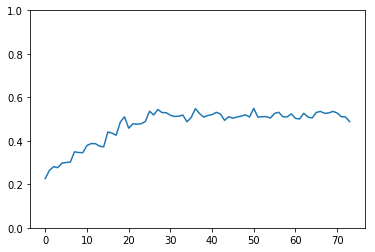

In [15]:
scores_comp = 0
max_k = len(X.columns)
f1_scores = []

for i in range(1):
    rar_data = pd.concat([X_train, y_train], axis=1)
    # RaR uses columns with string label only
    rar_data.rename(columns=lambda c: str(c), inplace=True)
    rar_compensate = wrar.rar.RaR(rar_data)
    rar_compensate.run(str(target), k=5, runs=100, split_iterations=10, compensate_imbalance=True, weight_mod=3)

    # Evaluate, average relative error rates
    score = pd.DataFrame(columns=np.unique(data[target]), index=np.arange(max_k)).fillna(0)
    for i in range(1, max_k):
        errors, f1 = eval_rar_ranking(rar_compensate.feature_ranking, target, k=i)
        f1_scores.append(f1)
        print(f1)
        for label in errors.columns:
            score.loc[i, label] = errors[label][0]
        
    scores_comp += score
scores_comp /= 1

import matplotlib.pyplot as plt
#for label in scores_comp.columns:
#    plt.plot(scores_comp[label], label='Class {}'.format(label))
plt.plot(f1_scores)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
axes = plt.gca()
axes.set_ylim([0, 1])
plt.savefig('Dev2_test6_imb_f1_3')
plt.show()

#### Benchmarking the increase in weighting

In [ ]:
# Redirect output for long sessions
import sys
sys.stderr=open("err.txt","w")
sys.stdout=open("logs_dev_test6.txt", "w")

In [ ]:
np.unique(data[target], return_counts=True)

In [ ]:
steps = [0.5, 1, 2, 4]
scores_comp = pd.DataFrame(columns=np.unique(data[target]), index=steps).fillna(0)

for i in steps:
    rar_data = pd.concat([X_train, y_train], axis=1)
    # RaR uses columns with string label only
    rar_data.rename(columns=lambda c: str(c), inplace=True)
    rar_compensate = wrar.rar.RaR(rar_data)
    rar_compensate.run(str(target), k=4, runs=100, split_iterations=10, compensate_imbalance=True, weight_mod=i)

    # Evaluate, average relative error rates
    errors, f1 = eval_rar_ranking(rar_compensate.feature_ranking, target, k=6)
    for label in errors.columns:
        scores_comp.loc[i, label] = errors[label][0]

import matplotlib.pyplot as plt
for label in scores_comp.columns:
    plt.plot(scores_comp[label], label='Class {}'.format(label))
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
axes = plt.gca()
axes.set_ylim([0, 1])
axes.set_ylabel('Relative error rate')
axes.set_xlabel('Weighting exponent')
plt.savefig('dev2_weight_higher_test6')
plt.show()

In [ ]:
scores

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores['Class 0'], label='Class 0')
plt.plot(scores['Class 1'], label='Class 1')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('RaR_test5_imb_nocomp')
plt.show()

In [ ]:
error_frame2 = eval_rar_ranking(rar_compensate.feature_ranking, k=4)
error_frame2

## Cost Analysis

### With selection

In [14]:
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import f1_score

def eval_rar_ranking(ranking, target, k=3):
    from imblearn.over_sampling import SMOTE
    
    clf_selected = ExtraTreesClassifier(n_jobs=-1)
    selected_features = list(map(lambda f: int(f[0]), ranking[:k]))
    X_train_s = X_train[selected_features]
    X_test_s = X_test[selected_features]
    
    # Rebalance
    sm = SMOTE()
    X_res, y_res = sm.fit_sample(X_train_s, y_train)
    
    clf_selected.fit(X_res, y_res)
    y_predict = clf_selected.predict(X_test_s)

    # print(classification_report_imbalanced(y_test, y_predict))
    f1 = f1_score(y_test, y_predict, average='macro')
    
    error_rates = dict([(value, {'sum': 0, 'errors': 0}) for value in np.unique(data[target])])
    for real, predicted in zip(y_test, y_predict):
        if real != predicted:
            error_rates[real]['errors'] += 1
        error_rates[real]['sum'] += 1

    error_frame = pd.DataFrame(index=[0], columns=np.unique(data[target]))
    for value, rates in error_rates.items():
        error_frame[value] = [rates['errors'] / (rates['sum'])]
    return error_frame, f1

### Without selection

In [ ]:
# Resampling for imbalanced learn
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)

In [ ]:
clf = ExtraTreesClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)
error_rates = dict([(value, {'sum': 0, 'errors': 0}) for value in np.unique(data[target])])
for real, predicted in zip(y_test, y_predict):
    if real != predicted:
        error_rates[real]['errors'] += 1
    error_rates[real]['sum'] += 1
error_frame = pd.DataFrame(index=[0], columns=np.unique(data[target]))
for value, rates in error_rates.items():
    error_frame[value] = [rates['errors'] / (rates['sum'])]
error_frame

In [ ]:
error_frame.iloc[0].mean()

In [ ]:
error_rates

In [ ]:
clf.score(X_test, y_test)

## DecisionTreeClassifier for Feature Ranking

In [ ]:
clf = ExtraTreesClassifier()
clf.fit(X_train[np.arange(10)], y_train)
clf.score(X_test[np.arange(10)], y_test)

In [ ]:
from imblearn.metrics import classification_report_imbalanced

classification_report_imbalanced(y_test, clf.predict(X_test))

In [ ]:
y_predict = clf.predict(X_test)
error_rates = dict([(value, {'sum': 0, 'errors': 0}) for value in np.unique(data[75])])
for real, predicted in zip(y_test, y_predict):
    if real != predicted:
        error_rates[real]['errors'] += 1
    error_rates[real]['sum'] += 1
error_frame = pd.DataFrame(index=[0], columns=np.unique(data[75]))
for value, rates in error_rates.items():
    error_frame[value] = [rates['errors'] / (rates['sum'])]
error_frame

In [ ]:
np.unique(data[75], return_counts=True)

In [ ]:
ranking = []
for index, importance in enumerate(clf.feature_importances_):
    ranking.append((data.columns[index], importance))
ranking.sort(key=lambda r: r[1], reverse=True)
for (index, rank) in enumerate(ranking):
        print('{}. {} with a score of {}'.format(index + 1, rank[0], rank[1]))

## Benchmarking with top k features

In [ ]:
import sys

scores = pd.DataFrame(columns=['RaR', 'DecisionTree'], index=np.arange(40))
scores = scores.fillna(0)
max_k = 40

# RaR
for i in range(1,max_k):
    clf_selected = ExtraTreesClassifier(max_features=i, n_jobs=-1)
    selected_features = list(map(lambda f: int(f[0]), rar.feature_ranking[:i]))
    X_train_s = X_train[selected_features]
    X_test_s = X_test[selected_features]
    clf_selected.fit(X_train_s, y_train)
    scores.loc[i, 'RaR'] = clf_selected.score(X_test_s, y_test)
    sys.stdout.write('\rBenchmark: {}%     '.format(100 * i / (2*max_k)))
    sys.stdout.flush()
    
# DecisionTree
for i in range(1,max_k):
    clf_selected = ExtraTreesClassifier(max_features=i, n_jobs=-1)
    selected_features = [r[0] for r in ranking[:i]]
    X_train_s = X_train[selected_features]
    X_test_s = X_test[selected_features]
    clf_selected.fit(X_train_s, y_train)
    scores.loc[i, 'DecisionTree'] = clf_selected.score(X_test_s, y_test)
    sys.stdout.write('\rBenchmark: {}%     '.format(50 + 100 * i / (2*max_k)))
    sys.stdout.flush()
print('Benchmark: 100.0%')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores['DecisionTree'], label='DecisionTree')
plt.plot(scores['RaR'], label='RaR')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('test4_FS_ExtraTrees_Score')
plt.show()

## Other

In [ ]:
# In case we need to look at the tree
from sklearn import tree
import pydot
from sklearn.externals.six import StringIO
dot_data = StringIO()
tree.export_graphviz(clf, out_file='tree.dot')